# Independence Tests Power over Increasing Sample Size

In [1]:
import sys, os
import multiprocessing as mp
from joblib import Parallel, delayed

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from power import power
from hyppo.independence import CCA, MGC, RV, Dcorr, Hsic, HHG
from hyppo.sims import indep_sim

sys.path.append(os.path.realpath('..'))

In [7]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

from hyppo.random_forest.base import RandomForestTest
from hyppo.random_forest._utils import _CheckInputs, sim_matrix
from hyppo._utils import perm_test, euclidean


FOREST_TYPES = {
    "classifier" : RandomForestClassifier,
    "regressor" : RandomForestRegressor
}


class KMERF(RandomForestTest):
    r"""
    Class for calculating the random forest based Dcorr test statistic and p-value.
    """

    def __init__(self, forest="regressor", ntrees=500, **kwargs):
        self.first_time = True
        if forest in FOREST_TYPES.keys():
            self.clf = FOREST_TYPES[forest](n_estimators=ntrees, **kwargs)
        else:
            raise ValueError("forest must be classifier or regressor")
        RandomForestTest.__init__(self)

    def _statistic(self, x, y):
        r"""
        Helper function that calculates the random forest based Dcorr test statistic.
        """
        if self.first_time:
            y = y.reshape(-1)
            self.clf.fit(x, y)
            self.first_time = False
        distx = np.sqrt(1 - sim_matrix(self.clf, x))
        y = y.reshape(-1, 1)
        disty = euclidean(y)
        stat = Dcorr(compute_distance=None)._statistic(distx, disty)
        self.stat = stat

        return stat

    def test(self, x, y, reps=1000, workers=1):
        r"""
        Calculates the random forest based Dcorr test statistic and p-value.
        """
        check_input = _CheckInputs(x, y, reps=reps)
        x, y = check_input()

        stat, pvalue, _ = perm_test(self._statistic, x, y, reps=reps, workers=workers, is_distsim=False)
        self.stat = stat
        self.pvalue = pvalue

        return stat, pvalue

In [22]:
import numpy as np
from hyppo.independence import Dcorr
from hyppo.sims import linear, spiral, multimodal_independence
from numpy.testing import assert_approx_equal

# @pytest.mark.parametrize(
#     "sim, obs_stat, obs_pvalue",
#     [
#         (linear, 0.97, 1 / 1000),  # test linear simulation
#         (spiral, 0.163, 1 / 1000),  # test spiral simulation
#         (multimodal_independence, -0.0094, 0.78),  # test independence simulation
#     ],
# )
def test_oned(sim, obs_stat, obs_pvalue):
    np.random.seed(12345678)

    # generate x and y
    x, y = sim(n=100, p=5)

    # test stat and pvalue
    stat1 = KMERF()._statistic(x, y)
    stat2, pvalue = KMERF().test(x, y)
    assert_approx_equal(stat1, obs_stat, significant=1)
    assert_approx_equal(stat2, obs_stat, significant=1)
    assert_approx_equal(pvalue, obs_pvalue, significant=1)
    
test_oned(spiral, 0.091, 0.001)

In [4]:
MAX_SAMPLE_SIZE = 100
STEP_SIZE = 5
SAMP_SIZES = range(5, MAX_SAMPLE_SIZE + STEP_SIZE, STEP_SIZE)
POWER_REPS = 5

SIMULATIONS = {
    "linear": "Linear",
    "exponential": "Exponential",
    "cubic": "Cubic",
    "joint_normal": "Joint Normal",
    "step": "Step",
    "quadratic": "Quadratic",
    "w_shaped": "W-Shaped",
    "spiral": "Spiral",
    "uncorrelated_bernoulli": "Bernoulli",
    "logarithmic": "Logarithmic",
    "fourth_root": "Fourth Root",
    "sin_four_pi": "Sine 4\u03C0",
    "sin_sixteen_pi": "Sine 16\u03C0",
    "square": "Square",
    "two_parabolas": "Two Parabolas",
    "circle": "Circle",
    "ellipse": "Ellipse",
    "diamond": "Diamond",
    "multiplicative_noise": "Multiplicative",
    "multimodal_independence": "Independence"
}

TESTS = [
    KMERF,
    MGC,
    Dcorr,
    Hsic,
    HHG,
    CCA,
    RV,
]

In [7]:
def estimate_power(sim, test):
    est_power = np.array([np.mean([power(test, sim, n=i, p=3) for _ in range(POWER_REPS)])
                          for i in SAMP_SIZES])
    np.savetxt('../rf/vs_samplesize/{}_{}.csv'.format(sim, test.__name__),
               est_power, delimiter=',')
    
    return est_power

In [8]:
outputs = Parallel(n_jobs=-1, verbose=100)(
    [delayed(estimate_power)(sim, test) for sim in SIMULATIONS for test in TESTS]
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  9.0min finished


In [9]:
sns.set(color_codes=True, style='white', context='talk', font_scale=1.5)
PALETTE = sns.color_palette("Set1")
sns.set_palette(PALETTE[1:5] + PALETTE[6:], n_colors=9)

In [10]:
def plot_power():
    fig, ax = plt.subplots(nrows=4, ncols=5, figsize=(25,20))
    plt.suptitle("Multivariate Independence Testing (Increasing Sample Size)", y=0.93, va='baseline')
    
    for i, row in enumerate(ax):
        for j, col in enumerate(row):
            count = 5*i + j
            sim = list(SIMULATIONS.keys())[count]
            
            for test in TESTS:
                test_name = test.__name__
                power = np.genfromtxt('../rf/vs_samplesize/{}_{}.csv'.format(sim, test.__name__),
                                      delimiter=',')
                hsic_power = np.genfromtxt('../rf/vs_samplesize/{}_Hsic.csv'.format(sim),
                                      delimiter=',')
                
                kwargs = {
                    "label": test.__name__,
                    "lw": 2,
                }
                if test_name in ["MGC", "KMERF"]:
                    kwargs["color"] = "#e41a1c"
                    kwargs["lw"] = 4
                    if test_name == "KMERF":
                        kwargs["linestyle"] = "dashed"
                
                col.plot(SAMP_SIZES, power - hsic_power, **kwargs)
                col.set_xticks([])
                if i == 3:
                    col.set_xticks([SAMP_SIZES[0], SAMP_SIZES[-1]])
                col.set_ylim(-1.05, 1.05)
                col.set_yticks([])
                if j == 0:
                    col.set_yticks([-1, 0, 1])
                col.set_title(SIMULATIONS[sim])
    
    fig.text(0.5, 0.07, 'Sample Size', ha='center')
    fig.text(0.07, 0.5, 'Statistical Power Relative to Hsic', va='center', rotation='vertical')
    leg = plt.legend(bbox_to_anchor=(0.5, 0.07), bbox_transform=plt.gcf().transFigure, ncol=len(TESTS),
                     loc='upper center')
    leg.get_frame().set_linewidth(0.0)
    for legobj in leg.legendHandles:
        legobj.set_linewidth(5.0)
    plt.subplots_adjust(hspace=.50)
    plt.savefig('../rf/figs/indep_power_sampsize.pdf', transparent=True, bbox_inches='tight')

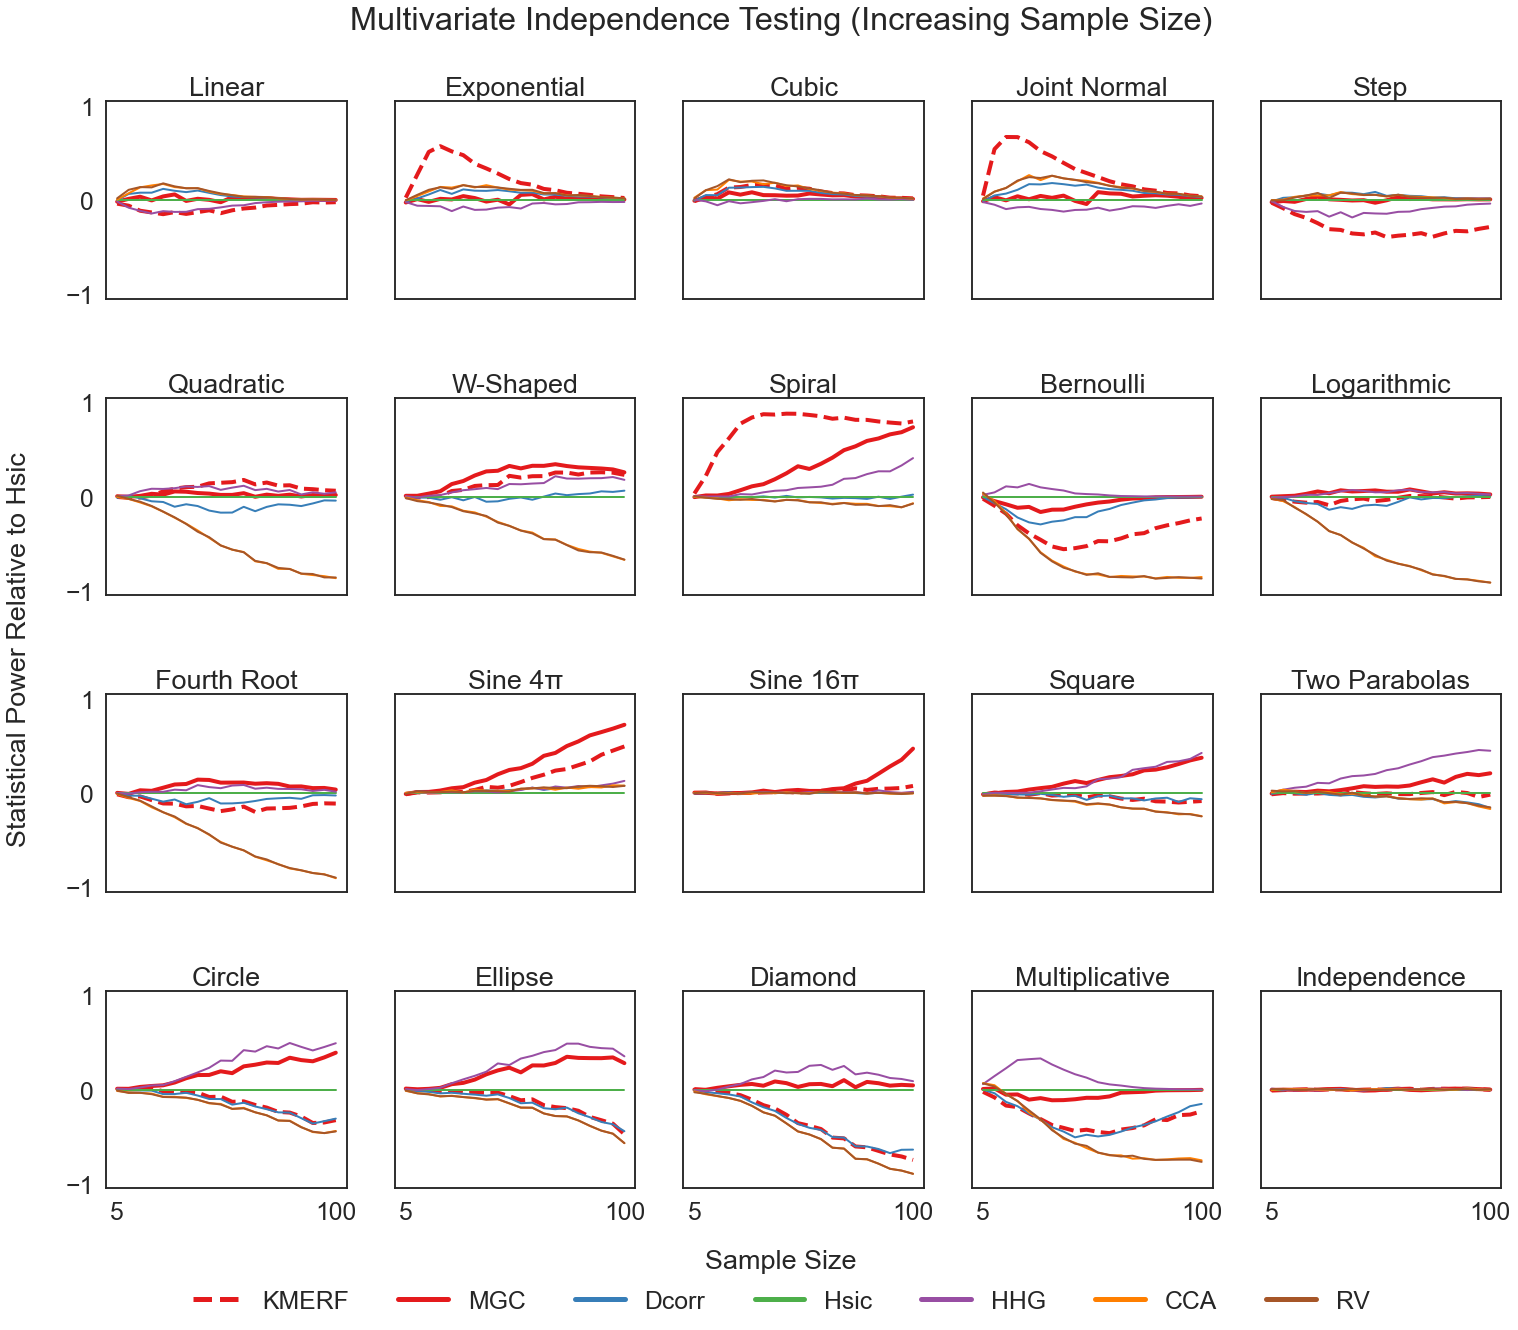

In [11]:
plot_power()